AI Exploration — Evidence Notebook (PDF‑safe, two datasets, clean text tables)

We have two piles of letters. One pile is perfect because we wrote each letter clearly and kept the boxes balanced. The other pile is real and messy. We will sort both piles into five boxes called delivery_issue, refund_request, billing_problem, app_bug, and other. We keep the view simple and make the tables PDF‑friendly by printing them as plain text boxes.


Finding the project root

A notebook inside notebooks often points to the wrong place when we use relative paths. We walk up until we see a folder that has data and src. That folder is our root.


In [4]:
from pathlib import Path

def find_project_root(max_up=8):
    here = Path.cwd().resolve()
    for p in [here, *here.parents][:max_up+1]:
        if (p/'data').exists() and (p/'src').exists():
            return p
    return here

ROOT = find_project_root()
DATA_RAW = ROOT/'data'/'raw'
MODELS = ROOT/'models'
FIGS = ROOT/'reports'/'figures'
MODELS.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

print('ROOT  :', ROOT)
print('RAW   :', DATA_RAW)
print('MODELS:', MODELS)
print('FIGS  :', FIGS)

ROOT  : C:\Users\ecsde\Documents\ai-exploration-customer-feedback
RAW   : C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw
MODELS: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\models
FIGS  : C:\Users\ecsde\Documents\ai-exploration-customer-feedback\reports\figures


Imports and small helpers

We keep tables as simple text using the tabulate library so they render in PDF. If tabulate is missing, install it once with pip install tabulate.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from tabulate import tabulate

pd.set_option('display.max_colwidth', 160)

def ellipsize(s, n=140):
    s = str(s).replace('\n',' ').strip()
    return s if len(s) <= n else s[:n-1] + '…'

def print_table(df, title=None):
    if title:
        print('\n' + title)
    print(tabulate(df, headers='keys', showindex=False, tablefmt='github'))

Loading the two piles

We look for customer_feedback_1000.csv (perfect) and customer_feedback_sample.csv (real). Both must have text and category columns.


In [6]:
def load_csv_if_exists(path: Path, tag: str):
    if path.exists():
        df = pd.read_csv(path)
        if {'text','category'}.issubset(df.columns):
            df = df.dropna(subset=['text','category']).drop_duplicates().reset_index(drop=True)
            print(f'Loaded {tag}:', path, 'rows =', len(df))
            return df
        else:
            print(f'Found {tag} at {path} but columns are {df.columns.tolist()} (need text, category)')
    else:
        print(f'{tag} not found at', path)
    return None

PERFECT_PATH = DATA_RAW/'customer_feedback_1000.csv'
REAL_PATH    = DATA_RAW/'customer_feedback_sample.csv'

df_perfect = load_csv_if_exists(PERFECT_PATH, 'perfect')
df_real    = load_csv_if_exists(REAL_PATH, 'real')

if df_perfect is None and df_real is None:
    raise FileNotFoundError('Place customer_feedback_1000.csv or customer_feedback_sample.csv under data/raw with columns: text, category.')

Loaded perfect: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw\customer_feedback_1000.csv rows = 1000
Loaded real: C:\Users\ecsde\Documents\ai-exploration-customer-feedback\data\raw\customer_feedback_sample.csv rows = 166263


One run of the sorter

We split with a fixed seed, build TF‑IDF features on single words and two‑word phrases, train Complement Naive Bayes, and then show compact plain‑text tables for the report and misclassifications. The confusion matrix is one clear plot.


In [7]:
from datetime import datetime

def vectorizer_default():
    return TfidfVectorizer(
        analyzer='word',
        ngram_range=(1,2),
        min_df=5,
        max_df=0.95,
        sublinear_tf=True,
        lowercase=True
    )

def run_once(df, tag):
    # Split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df['category']
    )
    # Vectorize
    vec = vectorizer_default()
    X_train = vec.fit_transform(train_df['text'])
    y_train = train_df['category'].values
    X_test  = vec.transform(test_df['text'])
    y_test  = test_df['category'].values

    # Train
    clf = ComplementNB(alpha=0.3)
    clf.fit(X_train, y_train)

    # Predict and metrics
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1m = f1_score(y_test, pred, average='macro')
    print(f'\n{tag} accuracy:', round(acc,3), '| macro-F1:', round(f1m,3))

    # Short classification report as text table
    rep = classification_report(y_test, pred, output_dict=True, zero_division=0)
    rep_df = (pd.DataFrame(rep).T
                .rename(columns={'precision':'prec','recall':'rec','f1-score':'f1','support':'n'}))
    order = [c for c in rep_df.index if c not in ('accuracy','macro avg','weighted avg')] + ['macro avg','weighted avg','accuracy']
    rep_df = rep_df.loc[order][['n','prec','rec','f1']].round(3).reset_index().rename(columns={'index':'label'})
    print_table(rep_df, title=f'{tag} classification report')

    # Confusion matrix
    labels = sorted(df['category'].unique())
    cm = confusion_matrix(y_test, pred, labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(cm, aspect='auto')
    ax.set_title(f'Confusion Matrix — {tag} (CNB)')
    ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right'); ax.set_yticklabels(labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i,j]), ha='center', va='center', fontsize=10)
    plt.tight_layout(); plt.show()
    fig.savefig(FIGS/f'confusion_matrix_{tag}.png', dpi=150)

    # Misclassified examples: compact, plain text
    proba = clf.predict_proba(X_test)
    maxp  = proba.max(axis=1)
    rows = []
    for true, pr, text, p in zip(y_test, pred, test_df['text'].tolist(), maxp):
        if true != pr:
            t = text.lower()
            if ('refund' in t or 'money back' in t or 'chargeback' in t) and ('charge' in t or 'fee' in t or 'statement' in t):
                reason = 'refund vs billing overlap'
            elif ('app' in t or 'mobile' in t or 'website' in t) and ('error' not in t and 'crash' not in t and 'login' not in t):
                reason = 'vague app wording'
            elif ('not received' in t or 'never received' in t or 'delivery' in t or 'arrived' in t) and ('tracking' not in t and 'delayed' not in t):
                reason = 'weak delivery cues'
            elif p < 0.55:
                reason = 'low confidence'
            else:
                reason = 'mixed or ambiguous'
            rows.append({'true': true, 'pred': pr, 'confidence': round(float(p),3), 'text': ellipsize(text), 'reason': reason})
    if rows:
        wrong_df = pd.DataFrame(rows).sort_values('confidence').head(12)
        print_table(wrong_df, title=f'{tag} misclassified examples (12 lowest confidence)')
        # Save full list for appendix use
        pd.DataFrame(rows).to_csv(ROOT/'reports'/f'misclassified_{tag}.csv', index=False, encoding='utf-8')
        print('Saved full misclassifications to', ROOT/'reports'/f'misclassified_{tag}.csv')
    else:
        print('No misclassifications to show.')

    # Top features per class: 8 per class, text table
    feature_names = np.array(vec.get_feature_names_out())
    logp = clf.feature_log_prob_
    rows = []
    for i, cls in enumerate(clf.classes_):
        others = np.delete(logp, i, axis=0)
        scores = logp[i] - others.mean(axis=0)
        top_idx = np.argsort(scores)[::-1][:8]
        for rank, j in enumerate(top_idx, 1):
            rows.append({'class': cls, 'rank': rank, 'feature': feature_names[j]})
    feats_df = pd.DataFrame(rows)
    print_table(feats_df, title=f'{tag} top informative words (8 per class)')

    # Save artifacts with tag
    import joblib
    joblib.dump(vec, MODELS/f'vectorizer_{tag}.joblib')
    joblib.dump(clf, MODELS/f'classifier_cnb_{tag}.joblib')

    return {'tag': tag, 'accuracy': acc, 'macro_f1': f1m}

Run both piles and compare in plain words

We run the perfect pile if present, then the real pile if present. If both are present, we write a short comparison in text so the story is readable in PDF.



perfect accuracy: 1.0 | macro-F1: 1.0

perfect classification report
| label           |   n |   prec |   rec |   f1 |
|-----------------|-----|--------|-------|------|
| app_bug         |  39 |      1 |     1 |    1 |
| billing_problem |  37 |      1 |     1 |    1 |
| delivery_issue  |  40 |      1 |     1 |    1 |
| other           |  45 |      1 |     1 |    1 |
| refund_request  |  39 |      1 |     1 |    1 |
| macro avg       | 200 |      1 |     1 |    1 |
| weighted avg    | 200 |      1 |     1 |    1 |
| accuracy        |   1 |      1 |     1 |    1 |


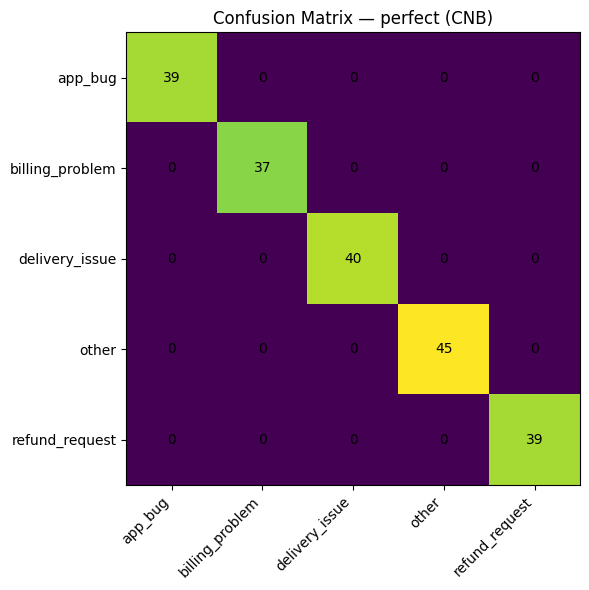

No misclassifications to show.

perfect top informative words (8 per class)
| class           |   rank | feature              |
|-----------------|--------|----------------------|
| app_bug         |      1 | get                  |
| app_bug         |      2 | to                   |
| app_bug         |      3 | since                |
| app_bug         |      4 | try to               |
| app_bug         |      5 | try                  |
| app_bug         |      6 | whenever             |
| app_bug         |      7 | whenever try         |
| app_bug         |      8 | the mobile           |
| billing_problem |      1 | balance              |
| billing_problem |      2 | there                |
| billing_problem |      3 | correct the          |
| billing_problem |      4 | on                   |
| billing_problem |      5 | please correct       |
| billing_problem |      6 | on my                |
| billing_problem |      7 | statement            |
| billing_problem |      8 | statement f

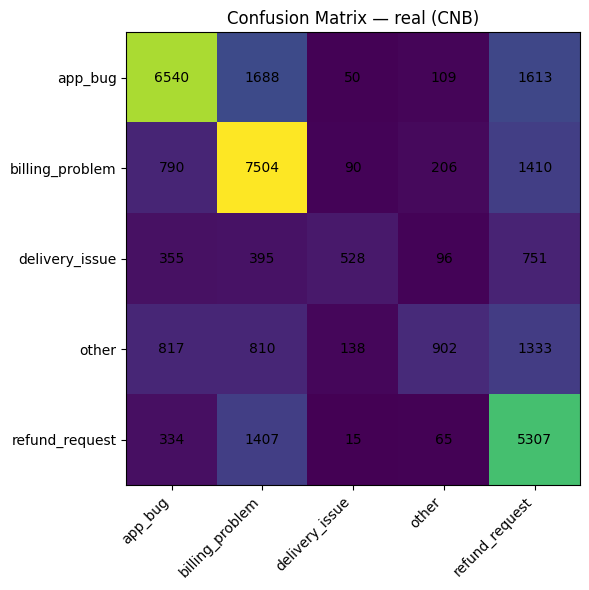


real misclassified examples (12 lowest confidence)
| true            | pred            |   confidence | text                                                                                                                                         | reason                    |
|-----------------|-----------------|--------------|----------------------------------------------------------------------------------------------------------------------------------------------|---------------------------|
| other           | delivery_issue  |        0.204 | I have been trying to reach Truist for months! I can not get a representative that can even see my accounts. There are 2. One was a secured… | low confidence            |
| other           | refund_request  |        0.205 | Thank you CFPB. In regards to complaints numbers XXXX & XXXX I 'm satisfied with the company 's response. Please cancel any further action.… | low confidence            |
| app_bug         | delivery_issue  |        0.205 |

In [8]:
summaries = []
if df_perfect is not None:
    summaries.append(run_once(df_perfect, 'perfect'))
if df_real is not None:
    summaries.append(run_once(df_real, 'real'))

if len(summaries) == 2:
    a, b = summaries
    print('\nComparison in words')
    print(f'Perfect set: accuracy {a["accuracy"]:.3f}, macro-F1 {a["macro_f1"]:.3f}.')
    print(f'Real set   : accuracy {b["accuracy"]:.3f}, macro-F1 {b["macro_f1"]:.3f}.')
    print(f'Delta (real - perfect): accuracy {(b["accuracy"]-a["accuracy"]):.3f}, macro-F1 {(b["macro_f1"]-a["macro_f1"]):.3f}.')
    print('The perfect set scores higher because the labels are clean and the messages are balanced.')
    print('The real set drops because refund and billing words overlap, delivery is often vague, and other is a mixed drawer.')
    print('Clean labels raise scores more than clever tricks. Keep a small hand‑labeled gold set to steer improvements.')

Closing thought

The student is the model and the teacher is the label. When the teacher is clear the student learns faster. Clean labels and tight boxes move the scores more than tweaks. Change one thing at a time and keep the seed fixed so the story stays honest on paper.
